In [209]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd

from matplotlib import rc

# Font settings
fontsize = 14

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : fontsize}

rc('font', **font)

In [210]:
class PODAnalysis:
	def __init__(self, snapshots):
		"""
		Initialize the POD analysis with the set of snapshots.
		
		Parameters:
		- snapshots: 2D array of system states (spatial (nx) x temporal (ns)). Each column is a snapshot at a different time.
		"""
		self.snapshots = snapshots
		self.modes = None
		self.singular_values = None
		self.reduced_basis = None
		self.dPHI_dx = None
		self.energy = None
		self.nx, self.ns = self.snapshots.shape
		self.x = np.linspace(0, 1, self.nx)
		self.t = np.linspace(0, 1, self.ns)
	
	def compute_pod(self):
		"""
		Perform POD analysis on the snapshots using Singular Value Decomposition (SVD).
		"""
		U, S, Vt = svd(self.snapshots, full_matrices=False)

		# Store the results
		self.modes = U  # Left singular vectors (POD modes or PHI)
		self.singular_values = S  # Singular values
		self.reduced_basis = Vt.T  # Right singular vectors (time coefficients)
		return self.modes

	def compute_dPHI_dx(self, dx):
		"""
		Compute the spatial derivative of POD modes.
		- dx: Spatial step size
		"""
		dPHI_dx = np.zeros_like(self.modes)
		
		# Central difference for interior points
		dPHI_dx[1:-1, :] = (self.modes[2:, :] - self.modes[:-2, :]) / (2 * dx)
		
		# Forward difference for the left boundary
		dPHI_dx[0, :] = (self.modes[1, :] - self.modes[0, :]) / dx
		
		# Backward difference for the right boundary
		dPHI_dx[-1, :] = (self.modes[-1, :] - self.modes[-2, :]) / dx

		self.dPHI_dx = dPHI_dx
		
		return self.dPHI_dx
	
	def optimal_modes(self, energy_threshold):
		""" 
		Identify the number of modes required to capture the specified energy threshold.
		Parameters: 
		- energy_threshold: The cumulative energy threshold (0 to 1). 
		Returns: 
		- index: The number of modes required. 
		- energy: The energy distribution of the modes. 
		"""
		# Explained energy by each mode (proportional to singular values)
		self.energy = (self.singular_values**2) / np.sum(self.singular_values**2)

		cum_energy = 0 # Initialize cumulative energy
		for index, value in enumerate(self.energy): 
			cum_energy += value 
			if cum_energy > energy_threshold: 
				break

		return index, self.energy

	def plot_energy(self):
		"""
		Plot the distribution of energy captured by each mode.
		"""
		mode_no = np.arange(1, len(self.energy) + 1, 1)
		
		plt.plot(mode_no, np.cumsum(self.energy), 'o-')
		plt.title('Energy Distribution by POD Modes', weight='bold')
		plt.xlabel('Mode Number', weight='bold')
		plt.ylabel('Cumulative Energy', weight='bold')
		plt.grid(True)
		# plt.legend()
		plt.show()

	def plot_modes(self, num_modes):
		"""
		Plot the first few POD modes.
		
		Parameters:
		- num_modes: Number of modes to plot
		"""
		for i in range(min(num_modes, self.modes.shape[1])):
			plt.plot(self.x, self.modes[:, i], label=f'Mode {i+1}')
		
			plt.title(f'POD Mode {i+1}', weight='bold')
			plt.xlabel('Normalized length', weight='bold')
			plt.ylabel('Mode Amplitude', weight='bold')
			# plt.legend()
			plt.grid(True)
			plt.show()

	def plot_snapshots(self, plot_individual_snapshots=True):
		"""
		Plots the evolution of the snapshots for the heat equation simulation.

		Parameters:
		- snapshots: numpy array of shape (nx, ns), the snapshots data.
		- plot_individual_snapshots: bool, if True, also plot individual snapshots as lines.
		"""
		# Plot the heatmap of snapshot evolution
		plt.figure(figsize=(8, 6))
		plt.imshow(self.snapshots, aspect='auto', cmap='hot', extent=[0, 1, 0, 1], origin='lower')
		plt.colorbar(label='Temperature')
		plt.xlabel('Space (x)', weight='bold')
		plt.ylabel('Time (normalized)', weight='bold')
		plt.title('Evolution of the Heat Equation Snapshots', weight='bold')
		plt.show()

		# Optionally, plot individual snapshots
		if plot_individual_snapshots:
			for i in range(0, self.ns, max(1, self.ns // 10)):  # Plot 10 evenly spaced snapshots
				plt.figure(figsize=(10, 6))
				plt.plot(self.x, self.snapshots[:, i], label=f'Snapshot {i}')
				plt.xlabel('Space (x)', weight='bold')
				plt.ylabel('Temperature', weight='bold')
				plt.title('Snapshots of the Heat Equation Over Time', weight='bold')
				plt.legend(loc='upper right')
				plt.show()


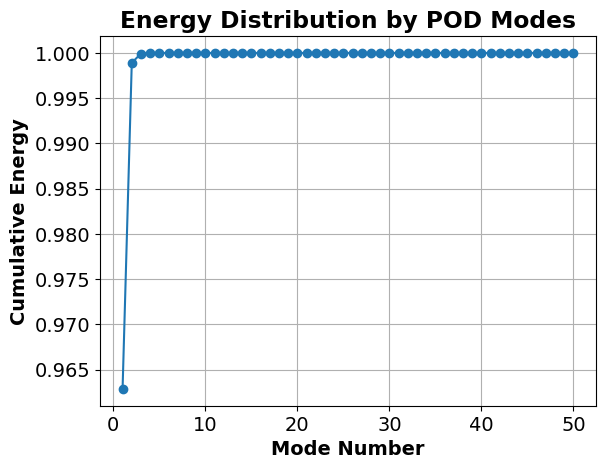

Explained Energy by Modes 1-6: [9.62868469e-01 3.60407217e-02 1.01592762e-03 7.44437751e-05
 4.32485512e-07 4.52028870e-09]


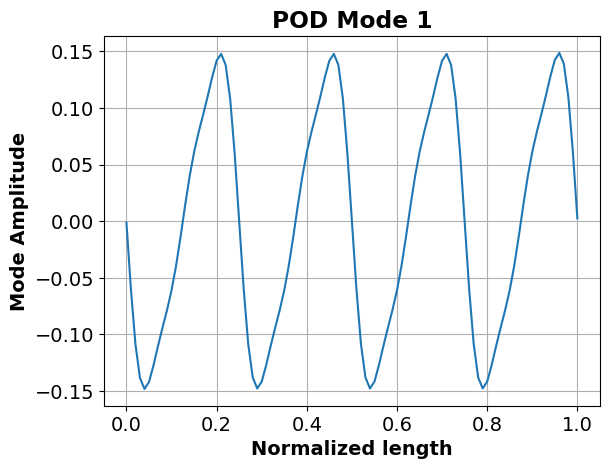

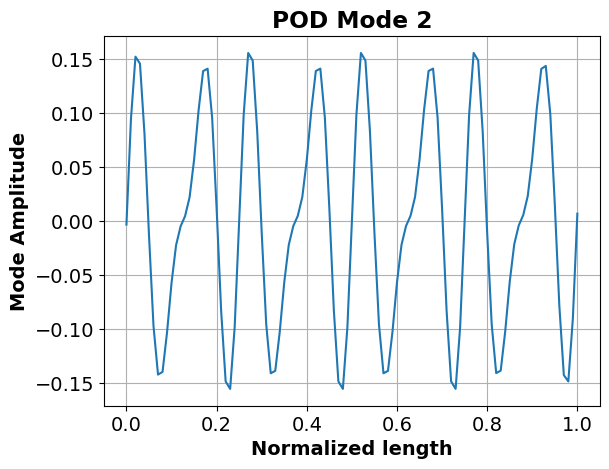

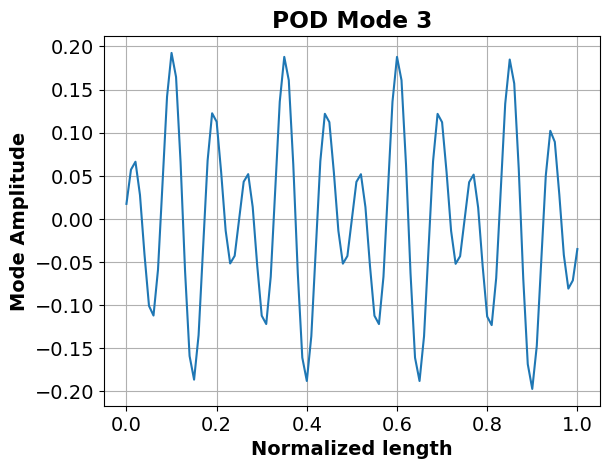

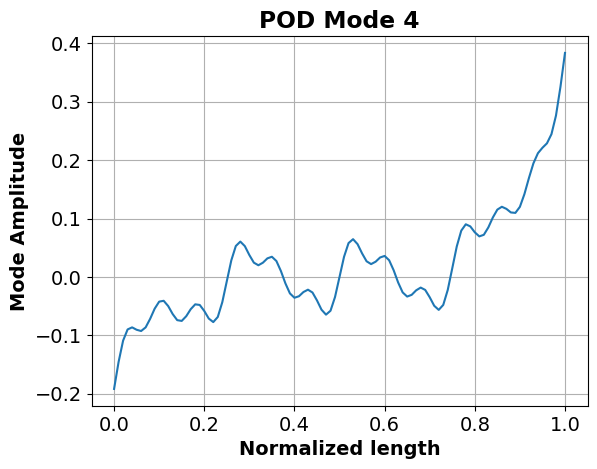

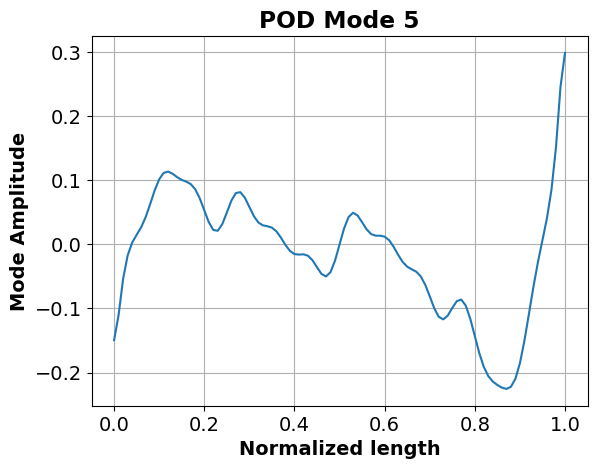

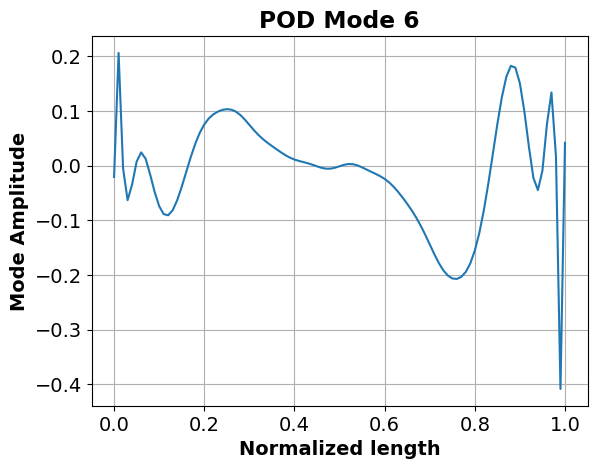

In [212]:
if __name__ == "__main__":
	# Load snapshots matrix generated from heat_eq.py (spatial x time snapshots)
	snapshots = np.load('snapshots.npy')  # Shape (nx, ns)

	# Perform POD analysis on the snapshots
	pod = PODAnalysis(snapshots)
	PHI = pod.compute_pod()
	dx = 0.01  # Spatial grid size
	dPHI_dx = pod.compute_dPHI_dx(dx)

	num_modes_ROM, energy = pod.optimal_modes(energy_threshold=0.9999999999) 

	# Plot the energy distribution
	pod.plot_energy()

	# Print the explained energy by the first few modes
	print(f"Explained Energy by Modes 1-{num_modes_ROM}: {energy[:num_modes_ROM]}")

	# Plot the first 3 modes
	pod.plot_modes(num_modes_ROM)
	
	# Plot snapshot evolution
    # pod.plot_snapshots()

	np.savez('POD_data_FOM.npz', PHI=PHI, dPHI_dx=dPHI_dx)

	# num_modes_ROM = 5 # no of modes for reduced order model

	# Save required POD modes for reduced order model
	np.savez('POD_data_ROM.npz', PHI=PHI[:,:num_modes_ROM], dPHI_dx=dPHI_dx[:,:num_modes_ROM])

